In [1]:
import IPython.core.display
import matplotlib

def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles()

In [2]:
%%html
<style type="text/css">
@import url('https://fonts.googleapis.com/css?family=Playfair+Display');


div.text_cell_render {font-family: 'Playfair Display', serif; color: #13213b; line-height: 145%; font-size:16px;}
</style>

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import pandas as pd
df = pd.read_csv("data/GMAA-040218.csv", header=None, skiprows=6, parse_dates=[0], names=['period', 'value'])
df.value = df.value.astype(int)

In [7]:
import numpy as np

train_range = df[df.period < '2014-01-01'].index
test_range = df[(df.period >= '2014-01-01')].index

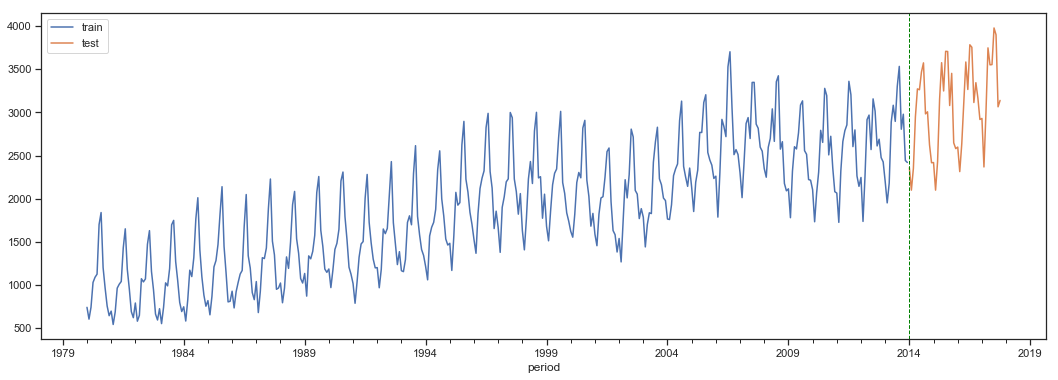

In [11]:
fig, ax = plt.subplots(figsize=(18,6))
df.loc[train_range].plot(x="period", y="value", ax=ax, label="train")
df.loc[test_range].plot(x="period", y="value", ax=ax, label="test")

plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='green', ls='--', lw=1)
plt.legend(loc='upper left')

plt.savefig('images/stochastic-split.png');

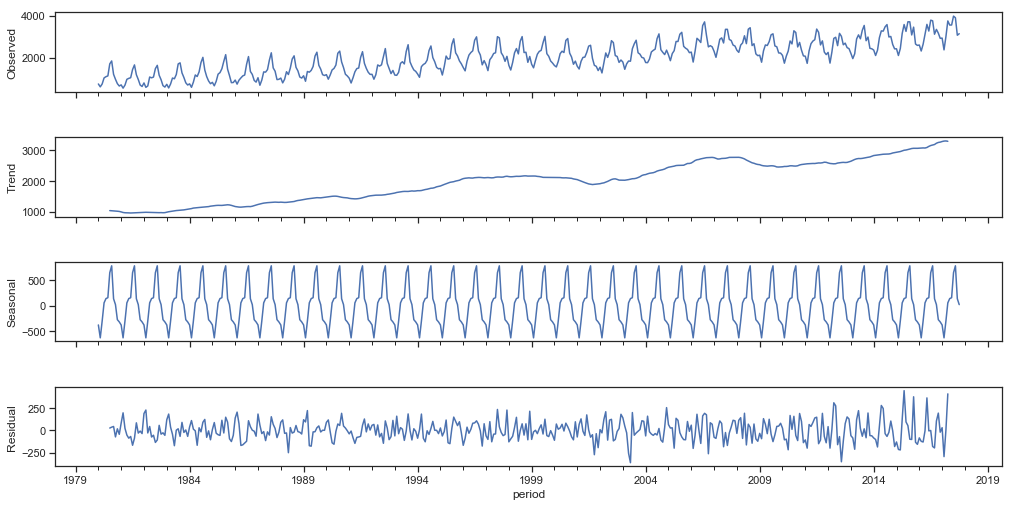

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasons = 12
decompfreq = seasons
model = 'additive'

decomposition = seasonal_decompose(
    df.set_index("period").value.interpolate("linear"),
    freq=decompfreq,
    model=model)

fig = decomposition.plot()
fig.set_size_inches(16, 8)

plt.savefig('images/stochastic-decomposition.png');

In [14]:
from statsmodels.tsa.stattools import adfuller

def is_stationary_with_adf(data, significance_level=0.01):
    """Decide if the given time series is stationary using ADF test."""
    test = adfuller(data, regression='c', autolag='BIC')
    p_value = test[1]
    print("ADF p-value: {:0.5f}".format(p_value))
    return p_value < significance_level

In [15]:
from statsmodels.tsa.stattools import kpss

def is_stationary_with_kpss(data, significance_level=0.05):
    """Decide if the given time series is stationary using KPSS test."""
    test = kpss(data, regression='c')
    p_value = test[1]
    print("KPSS p-value: {:0.5f}".format(p_value))
    return p_value > significance_level

In [16]:
significance_level = 0.05
print("Significance Level: {}%".format(100 * significance_level), '\n')

print("Stationary by ADF: {}".format(
    "yes" if is_stationary_with_adf(df.value.values, significance_level) else "no"), '\n')

print("Stationary by KPSS: {}".format(
    "yes" if is_stationary_with_kpss(df.value.values, significance_level) else "no"))

Significance Level: 5.0% 

ADF p-value: 0.95519
Stationary by ADF: no 

KPSS p-value: 0.01000
Stationary by KPSS: no


D:\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [69]:
from scipy import stats
df['boxcox'], lmbda = stats.boxcox(df.value)

print("Stationary by ADF: {}".format(
    "yes" if is_stationary_with_adf(df.boxcox.dropna().values, significance_level) else "no"), '\n')

print("Stationary by KPSS: {}".format(
    "yes" if is_stationary_with_kpss(df.boxcox.dropna().values, significance_level) else "no"))

ADF p-value: 0.91430
Stationary by ADF: no 

KPSS p-value: 0.01000
Stationary by KPSS: no


In [70]:
df["fd"] = df.boxcox - df.boxcox.shift(1)

In [71]:
df["stationary"] = df.fd - df.fd.shift(seasons)

In [72]:
print("Stationary by ADF: {}".format(
    "yes" if is_stationary_with_adf(df.stationary.dropna().values, significance_level) else "no"), '\n')

print("Stationary by KPSS: {}".format(
    "yes" if is_stationary_with_kpss(df.stationary.dropna().values, significance_level) else "no"))

ADF p-value: 0.00000
Stationary by ADF: yes 

KPSS p-value: 0.10000
Stationary by KPSS: yes


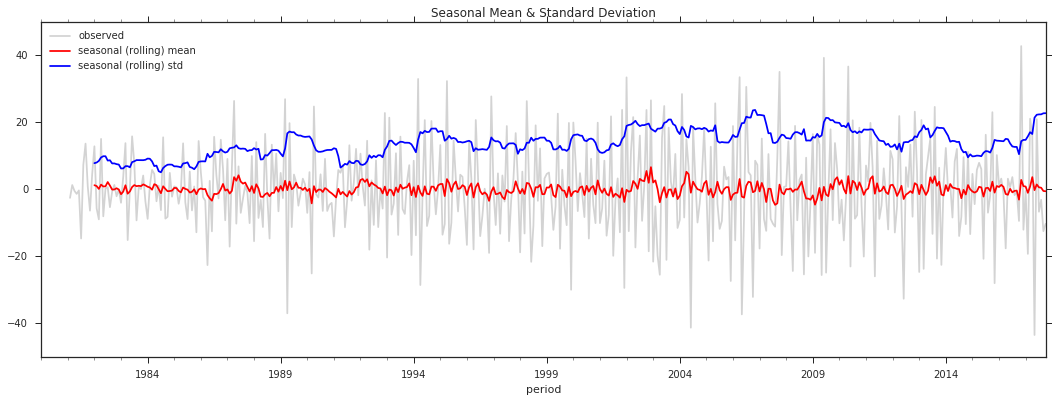

In [73]:
visual_check(df, "stationary", seasons, "images/stochastic-visual-mean-deviation-after-stationarization.png")

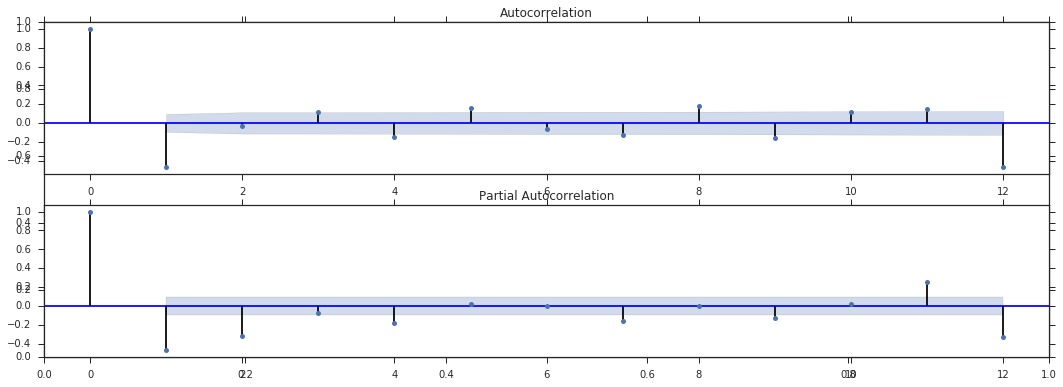

In [74]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(18,6))

ax = fig.add_subplot(211)
fig = plot_acf(df.stationary.dropna(inplace=False).iloc[seasons + 1:], lags=12, ax=ax)

ax = fig.add_subplot(212)
fig = plot_pacf(df.stationary.dropna(inplace=False).iloc[seasons + 1:], lags=12, ax=ax)

plt.savefig('images/stochastic-acf-pacf.png');

In [75]:
from statsmodels.tsa.statespace import sarimax

model = sarimax.SARIMAX(
    np.log(df.loc[train_range].set_index("period").value),
    trend='n',
    order=(1,1,1),
    seasonal_order=(1,1,0,12),
    enforce_stationarity=True,
    enforce_invertibility=True)
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  408
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 477.947
Date:                            Fri, 20 Apr 2018   AIC                           -947.894
Time:                                    14:50:11   BIC                           -931.849
Sample:                                01-01-1980   HQIC                          -941.545
                                     - 12-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0509      0.075      0.682      0.495      -0.095       0.197
ma.L1         -0.6821      0.051   

## Make prediction

In [76]:
steps = test_range.shape[0]

forecast = results.get_forecast(steps=steps)
forecast_ci = forecast.conf_int()

yhat_test = np.exp(forecast.predicted_mean).values
y_test = df.loc[test_range].value.values

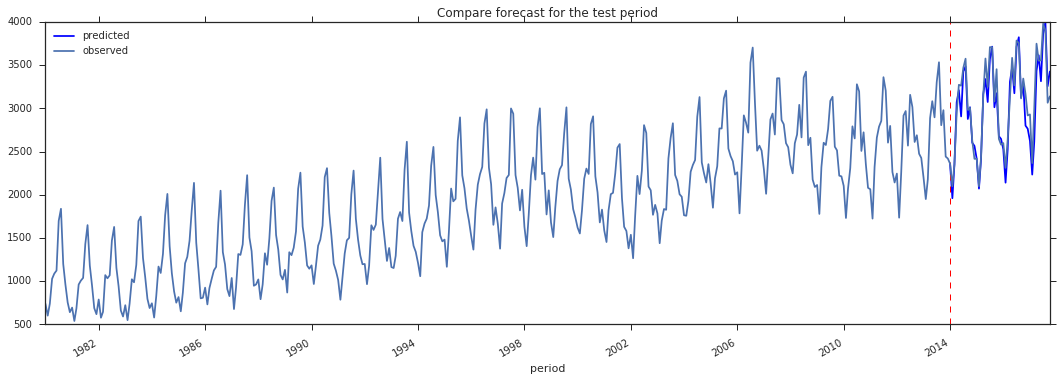

In [77]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='red', ls='--', lw=1)
df.plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Compare forecast for the test period')

plt.savefig('images/stochastic-forecast-testrange.png')
plt.show();

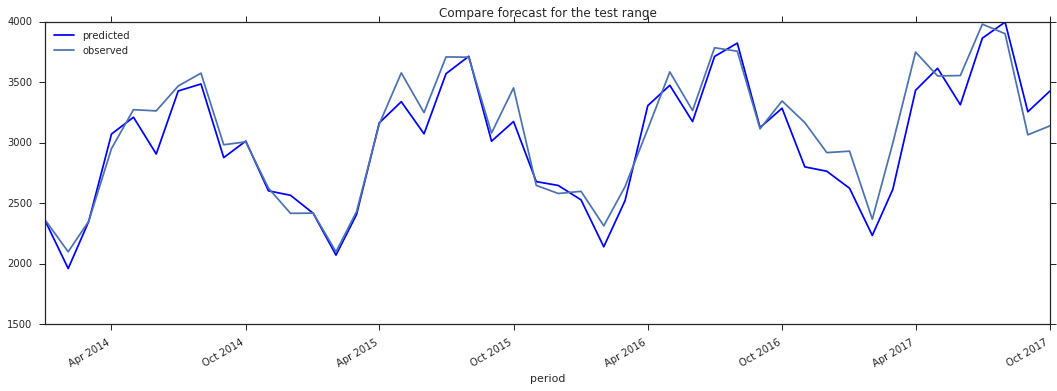

In [78]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the test range')

plt.savefig('images/stochastic-forecast-testrange-zoom.png')
plt.show();

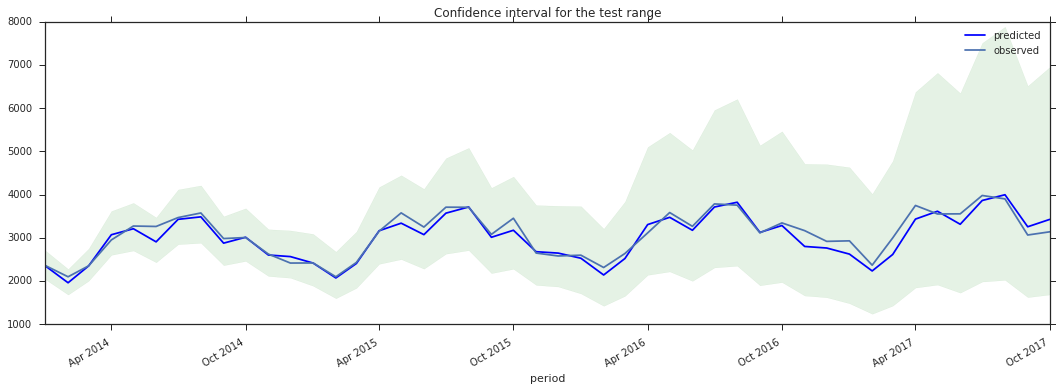

In [79]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

ax.fill_between(
    forecast_ci.index.to_pydatetime(),
    np.exp(forecast_ci['lower value']),
    np.exp(forecast_ci['upper value']),
    color='g',
    alpha=0.1)

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Confidence interval for the test range')

plt.savefig('images/stochastic-forecast-testrange-confidence-interval.png')
plt.show();

### Evaluate the forecast

In [80]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def theils_u_metric(y_true, y_pred):
    """Calculate Theil's U statistics using observed and predicted vectors."""
    SS_res =  np.mean(np.square(y_true - y_pred))
    SS_true = np.mean(np.square(y_true))
    SS_pred = np.mean(np.square(y_pred))
    
    return np.sqrt(SS_res / (SS_true * SS_pred))

In [81]:
mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)
r2 = r2_score(y_test, yhat_test)
u = theils_u_metric(y_test, yhat_test)

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("U   (test): {:0.6f}".format(u))

MAE (test): 126
MSE (test): 27015
R2  (test): 0.896
U   (test): 0.000017
